### Exploring the annotated data.


In [2]:
from datasets import load_dataset
import pandas as pd

# can infer the generic loader script this easily
ds = load_dataset("./data/annotated/")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test'],
        num_rows: 19622
    })
})

In [3]:
# how much faster would datasets be...

from annotate import annotate_shader, try_shader
import os

# all .jsonl files in ./data/raw/
raw_files = os.listdir("./data/raw/")
raw_files = [f for f in raw_files if f.endswith(".jsonl")]
raw_ds = load_dataset("json", data_files=["./data/raw/" + f for f in raw_files])
raw_ds
info_ds = raw_ds.map(lambda x: x["Shader"]["info"])
info_ds
# annotated_ds = raw_ds.map(annotate, fn_kwargs={"test": False, "access": "shaders20k"}, batched=False, num_proc=4)

# merge the "published" column from info_ds into ds, and align by "id"ArithmeticError
ds["train"] = ds["train"].add_column("published", info_ds["train"]["published"])

ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published'],
        num_rows: 19622
    })
})

In [4]:
from annotate import parse_functions

def add_functions(row):
    funcs = parse_functions(row["image_code"])
    return {"functions": funcs}

ds = ds.map(add_functions)


In [5]:
from annotate import try_shader
# TODO: make async for multithreading?
def run_test(ex):
    # print(ex)
    for rp in ex["Shader"]["renderpass"]:
        if rp["type"] == "image":
            image_code = rp["code"]
    if not image_code:
        return {"wgpu-test": "untested"}

    res = try_shader(shader_data=ex, image_code=image_code)
    return {"wgpu-test" :res}
# hangs on 344
# raw_ds = raw_ds.map(run_test, num_proc=1, batched=False)

In [6]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv
print(ds["train"].unique("license"))
# filter permissive licenses
ds["train"].filter(lambda x: x["license"] in "mit apache-2.0")

['CC-BY-NC-SA-3.0', 'cc-by-nc-sa-3.0', 'bsd-new', 'mit', 'cc-by-4.0', 'cc-by-nc-nd-3.0', 'bsd-simplified', 'cc0-1.0', 'unknown-license-reference', 'public-domain', 'apache-2.0', 'cc-by-nc-sa-4.0', 'agpl-3.0', 'cc-by-sa-4.0', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-sa-3.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'wtfpl-2.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'cc-by-nc-nd-4.0', 'unlicense', 'x11', 'proprietary-license', 'cc-by-3.0', 'cc-by-4.0 OR cc-by-3.0', 'gpl-3.0-plus', 'cc-by-nc-4.0', 'cc-by-nc-3.0', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-3.0', 'warranty-disclaimer', 'gpl-1.0-plus', 'cc-sampling-plus-1.0']


Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published', 'functions'],
    num_rows: 374
})

In [7]:
# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published', 'functions'],
    num_rows: 0
})

<Axes: xlabel='date'>

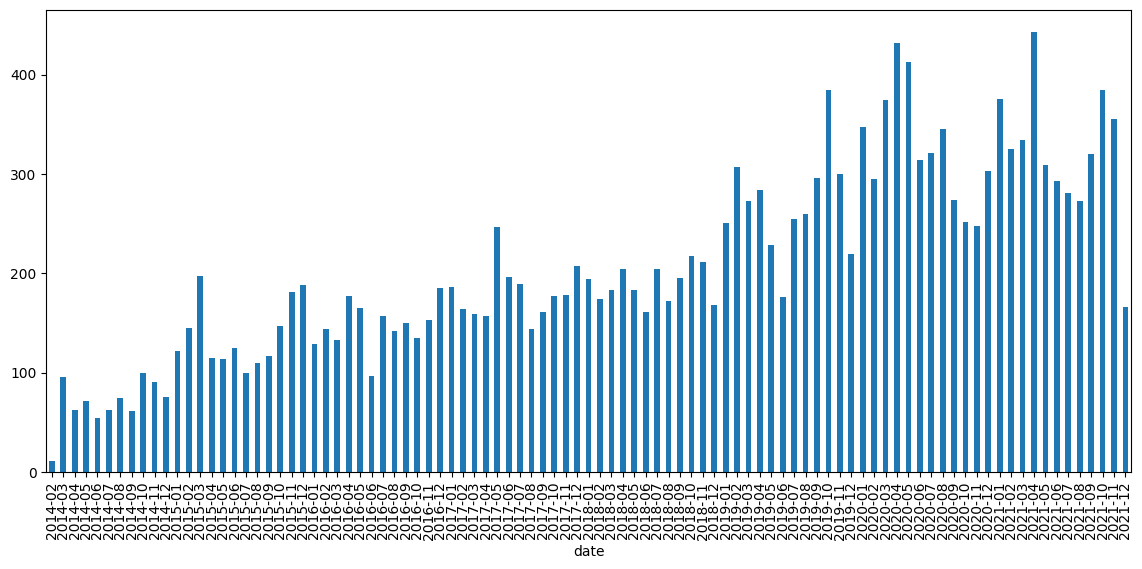

In [8]:
import pandas as pd
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
# plot entried per month as bars
df["date"].groupby(df["date"].dt.to_period("M")).count().plot(kind="bar", figsize=(14,6))

<Axes: xlabel='date'>

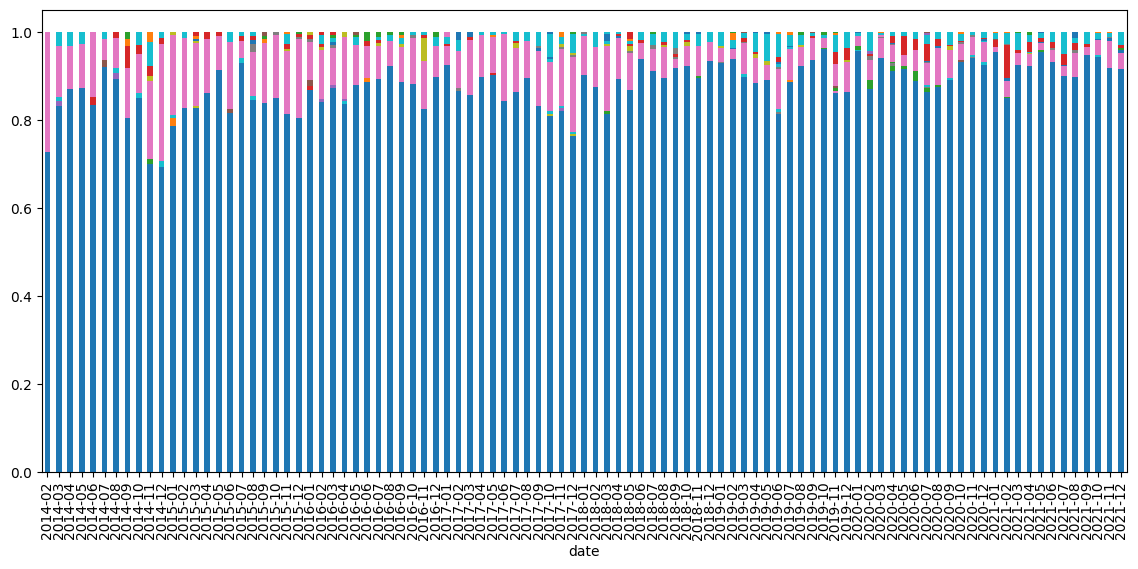

In [9]:
# plot stacked and streched bars of licenses per month
licenses = df["date"].groupby([df["date"].dt.to_period("M"), df["license"]]).count().unstack()
licenses = licenses.div(licenses.sum(axis=1), axis=0)
licenses.plot(kind="bar", stacked=True, figsize=(14,6), mark_right=True, legend=False)

<Axes: xlabel='date'>

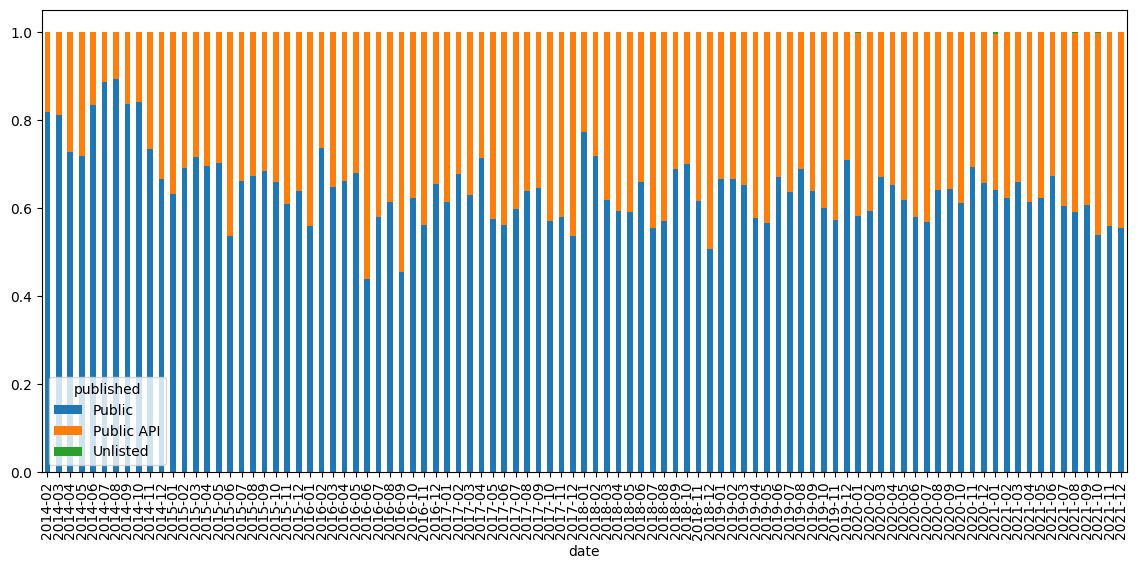

In [10]:
# plot stacked and streched bars of publishing privacy setting per month
privacies = df["date"].groupby([df["date"].dt.to_period("M"), df["published"]]).count().unstack()
privacies = privacies.div(privacies.sum(axis=1), axis=0)
privacies.plot(kind="bar", stacked=True, figsize=(14,6), mark_right=True, legend=True)

In [11]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         8.108450
std         10.439794
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        358.000000
Name: num_functions, dtype: float64

In [12]:
df["functions"].head()

0    [[1, 1, 22, 22, 71], [73, 73, 94, 94, 143], [1...
1    [[517, 517, 598, 598, 673], [675, 675, 766, 76...
2    [[594, 1189, 1217, 1217, 1310], [1312, 1312, 1...
3        [[0, 0, 30, 30, 86], [88, 88, 145, 145, 816]]
4    [[262, 282, 303, 303, 717], [719, 719, 758, 75...
Name: functions, dtype: object

In [28]:
from glm import column


columns_names=["start_comment", "start_header", "end_header", "end_docstring", "end_function"]
# supposed to use .to_list but it doesn't work as expected...

def unpack(row):
    return {v:row[0]["functions"][k] for v,k in enumerate(columns_names)}

f_df = df["functions"].explode()
# f_df = f_df.tolist()
f_df = pd.DataFrame(f_df)
f_df = f_df["functions"].apply(unpack)
f_df

IndexError: invalid index to scalar variable.

In [12]:
all_indicies = [f for fs in ds["train"]["functions"] for f in fs]
print(len(all_indicies))
indices_df = pd.DataFrame(all_indicies, columns=["start_comment", "start_header", "end_header", "end_docstring", "end_function"])
indices_df["has_comment"] = indices_df["start_comment"] != indices_df["start_header"]
indices_df["has_docstring"] = indices_df["end_header"] != indices_df["end_docstring"]

159104


In [13]:
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(indices_df["has_comment"], indices_df["has_docstring"], margins=True)
print(f"functions with contet = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

functions with contet = 44551


has_docstring,False,True,All
has_comment,,,
False,114553,8405,122958
True,32081,4065,36146
All,146634,12470,159104
